<a href="https://colab.research.google.com/github/barbaroja2000/clustering/blob/main/look_a_like_sample_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toy example using PCA and k-means to generate labels for a multi-class classification problem

This abstracted approach can be used for look-a-like modelling for customer profiling, for example identify a cluster of customers that are high value, then periodically run this on your customer database to identify new/existing customers that exhibit the same traits for additional marketing.


In [1]:
!pip install kneed > /dev/null

## Step 1: Generate a Sample Dataset
We'll create a synthetic dataset with ten clusters using the make_blobs function.

In [45]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
n_features = 10

# Generate synthetic data with 10 clusters
X, _ = make_blobs(n_samples=10000, centers=10, n_features=n_features, random_state=42)

# Add Gaussian noise to the data
noise_factor = 3
X += noise_factor * np.random.randn(*X.shape)

# Split the data into training and testing sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

## Step 2: Preprocess and Apply PCA
We'll standardize the data and apply PCA to reduce the dimensionality.

### Find the optimum number of principal components

In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.cluster import KMeans
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply PCA with all components
pca_all = PCA()
X_train_pca_all = pca_all.fit_transform(X_train_scaled)

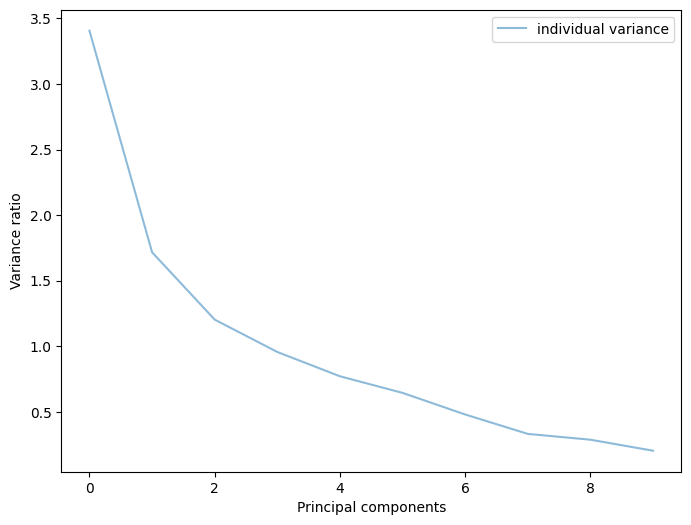

In [47]:
pca_variance = pca_all.explained_variance_

plt.rcParams.update(plt.rcParamsDefault)

plt.figure(figsize=(8, 6))
plt.plot(range(n_features), pca_variance, alpha=0.5, label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

In [48]:
kl = KneeLocator(range(1, n_features+1), pca_variance, curve="convex", direction="decreasing")
elbow = kl.elbow

### Plot the variance

### Apply optimum number

In [49]:
# Standardize, apply PCA, and perform k-means clustering on the noisy data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pca = PCA(n_components=elbow)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
kmeans = KMeans(n_clusters=10, random_state=42, n_init="auto")
y_train = kmeans.fit_predict(X_train_pca)

### Display the first two principal components

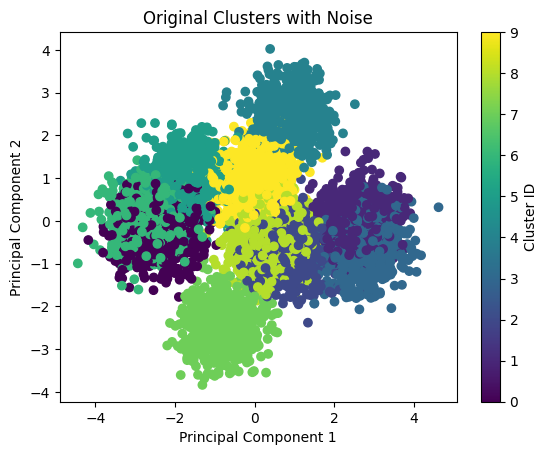

In [43]:
# Plot the original clusters with noise
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis')
plt.title('Original Clusters with Noise')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster ID')
plt.show()

### Display the first three optimum components

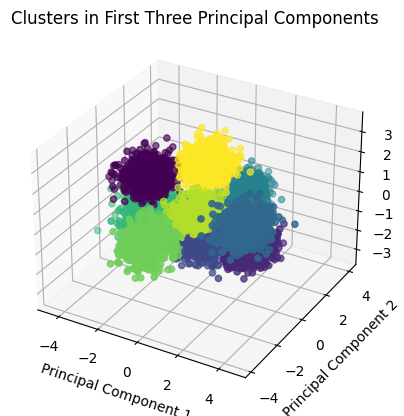

In [44]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2], c=y_train, cmap='viridis')
ax.set_title('Clusters in First Three Principal Components')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

## Step 3: Apply k-means Clustering to Generate Labels
We'll use k-means clustering to identify three clusters and use these as labels.

In [50]:
from sklearn.cluster import KMeans


# Assign test labels based on nearest cluster centroid
y_test = kmeans.predict(X_test_pca)

## Step 4: Train a Classification Model
We'll train a simple classifier using the clusters as labels.

In [51]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca, y_train)


from sklearn.metrics import precision_score, recall_score, f1_score

# Predict the cluster assignments for the test data
y_pred = clf.predict(X_test_pca)

# Compute precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
# Evaluate the classifier
accuracy = clf.score(X_test_pca, y_test)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')




Accuracy: 0.9885
Precision: 0.9871599090323466
Recall: 0.9864436228153581
F1-Score: 0.9867178688338916


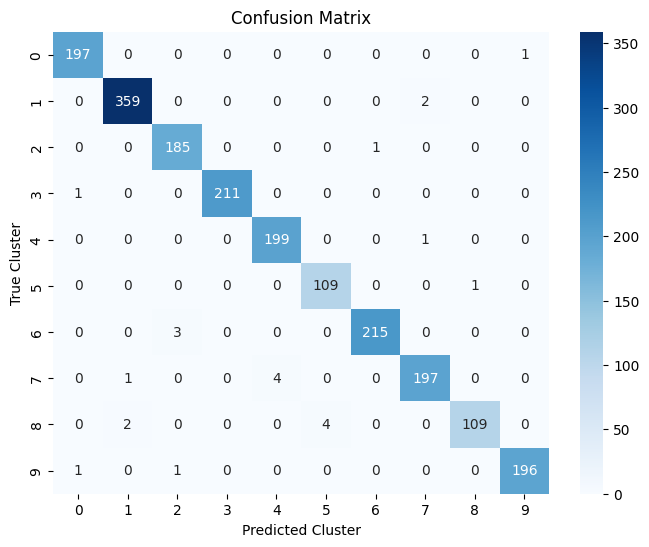

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the cluster assignments for the test data
y_pred = clf.predict(X_test_pca)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Cluster')
plt.ylabel('True Cluster')
plt.show()

## Testing on a single observation

In [53]:
# Assume single_observation is a single observation with the same number of features as the original data
single_observation = X_test[0]
actual_label = y_test[0]

# Preprocess the single observation (scaling)
single_observation_scaled = scaler.transform([single_observation])

# Apply PCA transformation
single_observation_pca = pca.transform(single_observation_scaled)

# Predict the cluster assignment using the trained classifier
predicted_cluster = clf.predict(single_observation_pca)

print(f'Predicted Cluster for Single Observation: {predicted_cluster[0]}')
print(f'Actual Cluster for Single Observation: {actual_label}')

Predicted Cluster for Single Observation: 1
Actual Cluster for Single Observation: 1
